In [48]:
import pandas as pd
from pathlib import Path
from os import listdir
import os.path
from collections import defaultdict
import re
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.style.use('seaborn')
sns.set(font_scale=2.3) 
sns.set_style("white")
mpl.rcParams["font.family"] = "Times New Roman"    


In [5]:
repo_dir = Path("/home/luk/repos/RAPid-Learn/data")
experiment_id = "5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon"


In [6]:
novelties = ["axetobreakhard", "scrapeplank", "axefirecteasy", "firecraftingtablehard"]
PRENOVELTY_TRANSFER_TRIAL_IDS = {"5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon": 1,
                                "ce84fd25cf54415bb3885a37d63e37a1-2021-10-05_10:20:18-policy_gradient-10000episodes-rewardshapingon": 2}

In [7]:
def extract_number(f):
    s = re.findall("\d+", f)
    return int(s[0]) if s else -1

In [8]:
csvs_per_novelty = defaultdict(list)
for experiment_id in PRENOVELTY_TRANSFER_TRIAL_IDS.keys():
    experiment_path = repo_dir / experiment_id    
    for novelty in novelties:
        for trial_dir in listdir(experiment_path / novelty):
            if os.path.isdir(experiment_path / novelty / trial_dir):
                for filename in os.listdir(experiment_path / novelty / trial_dir):
                    if filename.endswith(".csv"):
                        csvs_per_novelty[novelty].append(experiment_path / novelty / trial_dir / filename)       

In [9]:
csvs_per_novelty

defaultdict(list,
            {'axetobreakhard': [PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/trial-4/axetobreakhard-4-monitor.csv'),
              PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/trial-1/axetobreakhard-1-monitor.csv'),
              PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/trial-2/axetobreakhard-2-monitor.csv'),
              PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/trial-6/axetobreakhard-6-monitor.csv'),
              PosixPath('/home/luk/repos/RAPid-Learn/data/5bcc1f9ee3394fd49c784d356b806992-2021-10-05_16:52:30-PPO-10000episodes-rewardshapingon/axetobreakhard/tria

In [10]:
dfs = []
for novelty in novelties:
    for csv_path in csvs_per_novelty[novelty]:
            
        trial_id = extract_number(str(os.path.basename(os.path.normpath(csv_path))))
        print(f"novelty: {novelty}, trialid: {trial_id}")
        df = pd.read_csv(csv_path, skiprows=[0])
        if "policy_gradient" in str(csv_path):
            df["experiment"] = "policy_gradient"
        else:
            df["experiment"] = "PPO"

        df["trial"] = trial_id
        df["novelty"] = novelty
        
        df["ts_trained"] = df["l"].loc[df['mode'] == "learn"].cumsum()
        df["ts_trained"].ffill(inplace=True)
        
        during_learning_eval_rows = df.loc[(df['episode_counter'] != df['episode_counter'].max()) & (df['mode'] == "eval")]
        # Any trial that ran fewer than the max number of episodes converged
        during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
        
        print(during_learning_eval_rows)
        dfs.append(during_learning_eval_rows)
        df = df.loc[df["mode"] == "eval"]
        print(df)
        
results_df = pd.concat(dfs).reset_index(drop=True)

novelty: axetobreakhard, trialid: 4
        r    l         t  success  mode  episode_counter experiment  trial  \
101  1651  149  51.33943     True  eval              102        PPO      4   
102  1636  164  51.54692     True  eval              102        PPO      4   
103  1589  211  51.79391     True  eval              102        PPO      4   
104  -150  500  52.41739    False  eval              102        PPO      4   
105  1701   99  52.54127     True  eval              102        PPO      4   
106  1635  115  52.68014     True  eval              102        PPO      4   
107  1568  132  52.84311     True  eval              102        PPO      4   
108  -100  500  53.42833    False  eval              102        PPO      4   
109  1637  163  53.63949     True  eval              102        PPO      4   
110   300  500  54.27735    False  eval              102        PPO      4   
212  1665  135  90.05056     True  eval              203        PPO      4   
213  1525  225  90.34537    

/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

         r    l          t  success  mode  episode_counter       experiment  \
100   -400  500   42.53605    False  eval              100  policy_gradient   
101    200  500   42.96278    False  eval              100  policy_gradient   
102   -100  500   43.40214    False  eval              100  policy_gradient   
103   -400  500   43.81195    False  eval              100  policy_gradient   
104    200  500   44.28161    False  eval              100  policy_gradient   
...    ...  ...        ...      ...   ...              ...              ...   
5825  1617  183 1190.11098     True  eval             5300  policy_gradient   
5826  1571   79 1190.18871     True  eval             5300  policy_gradient   
5827  1607   93 1190.27053     True  eval             5300  policy_gradient   
5828  1687  113 1190.37886     True  eval             5300  policy_gradient   
5829  1714   86 1190.44862     True  eval             5300  policy_gradient   

      trial         novelty    ts_trained  converge

/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin


novelty: scrapeplank, trialid: 6
        r    l         t  success  mode  episode_counter experiment  trial  \
101  1330  170  46.68229     True  eval              102        PPO      6   
102  1201  299  47.01039     True  eval              102        PPO      6   
103  1349  151  47.17920     True  eval              102        PPO      6   
104  1265  235  47.44652     True  eval              102        PPO      6   
105  1428   72  47.53150     True  eval              102        PPO      6   
106  1162  338  47.93438     True  eval              102        PPO      6   
107  1443   57  48.01043     True  eval              102        PPO      6   
108  1401   99  48.12214     True  eval              102        PPO      6   
109  -300  500  48.68080    False  eval              102        PPO      6   
110  1343  157  48.87050     True  eval              102        PPO      6   
212  1438   62  77.91887     True  eval              203        PPO      6   
213  1428   72  78.01114     T

/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

         r    l         t  success  mode  episode_counter       experiment  \
100   1403   97  22.55879     True  eval              100  policy_gradient   
101   -300  500  22.87380    False  eval              100  policy_gradient   
102   -500  500  23.20015    False  eval              100  policy_gradient   
103   1176  324  23.41164     True  eval              100  policy_gradient   
104   1348  152  23.52561     True  eval              100  policy_gradient   
...    ...  ...       ...      ...   ...              ...              ...   
1883  1381  119 240.47017     True  eval             1628  policy_gradient   
1884  1420   80 240.53926     True  eval             1628  policy_gradient   
1885  1354  146 240.65431     True  eval             1628  policy_gradient   
1886  1443   57 240.69840     True  eval             1628  policy_gradient   
1887  1451   49 240.74303     True  eval             1628  policy_gradient   

      trial      novelty   ts_trained  
100      10  scrapeplan

/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

        r    l         t  success  mode  episode_counter experiment  trial  \
101  -300  500  81.72248    False  eval              102        PPO      8   
102  1546  254  82.18318     True  eval              102        PPO      8   
103  1466  434  82.94192     True  eval              102        PPO      8   
104  -100  500  83.73278    False  eval              102        PPO      8   
105  1568  232  84.08241     True  eval              102        PPO      8   
106  1467  233  84.44942     True  eval              102        PPO      8   
107  1618  182  84.76437     True  eval              102        PPO      8   
108   350  500  85.56423    False  eval              102        PPO      8   
109  1674  126  85.76359     True  eval              102        PPO      8   
110  1598  202  86.08216     True  eval              102        PPO      8   
212  1402  298 144.97755     True  eval              203        PPO      8   
213  1410  290 145.42867     True  eval              203        

/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin


novelty: axefirecteasy, trialid: 8
         r    l         t  success  mode  episode_counter       experiment  \
100   -200  500  46.76667    False  eval              100  policy_gradient   
101   -200  500  47.20703    False  eval              100  policy_gradient   
102   -200  500  47.63253    False  eval              100  policy_gradient   
103   1290  460  48.03712     True  eval              100  policy_gradient   
104   -300  500  48.47840    False  eval              100  policy_gradient   
...    ...  ...       ...      ...   ...              ...              ...   
1865  1482  318 660.89584     True  eval             1700  policy_gradient   
1866  1424  276 661.15717     True  eval             1700  policy_gradient   
1867  1487  163 661.33122     True  eval             1700  policy_gradient   
1868  1633  167 661.51256     True  eval             1700  policy_gradient   
1869  -100  500 662.03591    False  eval             1700  policy_gradient   

      trial        novelty 

/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

         r    l         t  success  mode  episode_counter experiment  trial  \
101   1675  125  80.47444     True  eval              102        PPO      9   
102   1632  118  80.67530     True  eval              102        PPO      9   
103   1462  338  81.23339     True  eval              102        PPO      9   
104   1500  200  81.56843     True  eval              102        PPO      9   
105   1684   66  81.68580     True  eval              102        PPO      9   
...    ...  ...       ...      ...   ...              ...        ...    ...   
1061  1660   40 458.20178     True  eval              887        PPO      9   
1062  1740   60 458.31072     True  eval              887        PPO      9   
1063  1603   97 458.48241     True  eval              887        PPO      9   
1064  1585   65 458.60273     True  eval              887        PPO      9   
1065  -200  500 459.44809    False  eval              887        PPO      9   

                    novelty   ts_trained  
101   fi

         r    l          t  success  mode  episode_counter       experiment  \
100    300  500   60.13187    False  eval              100  policy_gradient   
101   1346  404   60.66108     True  eval              100  policy_gradient   
102   1359  341   61.18585     True  eval              100  policy_gradient   
103   -100  500   61.89838    False  eval              100  policy_gradient   
104   -300  500   62.50542    False  eval              100  policy_gradient   
...    ...  ...        ...      ...   ...              ...              ...   
4615  1704   96 1370.68499     True  eval             4200  policy_gradient   
4616  1539  161 1370.88456     True  eval             4200  policy_gradient   
4617  1528   72 1370.97354     True  eval             4200  policy_gradient   
4618  1608   92 1371.09202     True  eval             4200  policy_gradient   
4619  -100  500 1371.75446    False  eval             4200  policy_gradient   

      trial                novelty   ts_trained  co

/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_learning_eval_rows["converged"] = during_learning_eval_rows["episode_counter"].max() <= 9998
/tmp/ipykernel_2381888/231570313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [11]:
dfs

[        r    l         t  success  mode  episode_counter experiment  trial  \
 101  1651  149  51.33943     True  eval              102        PPO      4   
 102  1636  164  51.54692     True  eval              102        PPO      4   
 103  1589  211  51.79391     True  eval              102        PPO      4   
 104  -150  500  52.41739    False  eval              102        PPO      4   
 105  1701   99  52.54127     True  eval              102        PPO      4   
 106  1635  115  52.68014     True  eval              102        PPO      4   
 107  1568  132  52.84311     True  eval              102        PPO      4   
 108  -100  500  53.42833    False  eval              102        PPO      4   
 109  1637  163  53.63949     True  eval              102        PPO      4   
 110   300  500  54.27735    False  eval              102        PPO      4   
 212  1665  135  90.05056     True  eval              203        PPO      4   
 213  1525  225  90.34537     True  eval            

In [56]:
per_trial_episode_df = results_df.groupby(by=["experiment", "novelty", "trial", "episode_counter"]).agg({'success': ['mean'], "episode_counter": "mean"}).reset_index()
per_trial_episode_df.columns = [' '.join(col).strip() for col in per_trial_episode_df.columns.values]
per_trial_episode_df

,experiment,novelty,trial,episode_counter,success mean,episode_counter mean
0,PPO,axefirecteasy,1,102,0.80000,102.00000
1,PPO,axefirecteasy,1,203,0.60000,203.00000
2,PPO,axefirecteasy,1,304,0.60000,304.00000
3,PPO,axefirecteasy,1,405,0.90000,405.00000
4,PPO,axefirecteasy,1,506,1.00000,506.00000
...,...,...,...,...,...,...
1157,policy_gradient,scrapeplank,10,1200,0.90000,1200.00000
1158,policy_gradient,scrapeplank,10,1300,0.70000,1300.00000
1159,policy_gradient,scrapeplank,10,1400,1.00000,1400.00000
1160,policy_gradient,scrapeplank,10,1500,1.00000,1500.00000


In [57]:
graph_df = per_trial_episode_df.groupby(by=["experiment", "novelty", "episode_counter"]).agg({'success mean': ['mean', 'std'], "episode_counter mean": "mean"}).reset_index()
graph_df.fillna(0, inplace=True)
graph_df.columns = [' '.join(col).strip() for col in graph_df.columns.values]
graph_df["lower_std"] = (graph_df["success mean mean"] - graph_df["success mean std"]).clip(lower=0)
graph_df["upper_std"] = (graph_df["success mean mean"] + graph_df["success mean std"]).clip(upper=1)

graph_df

,experiment,novelty,episode_counter,success mean mean,success mean std,episode_counter mean mean,lower_std,upper_std
0,PPO,axefirecteasy,102,0.68000,0.12293,102.00000,0.55707,0.80293
1,PPO,axefirecteasy,203,0.79000,0.11972,203.00000,0.67028,0.90972
2,PPO,axefirecteasy,304,0.86000,0.14298,304.00000,0.71702,1.00000
3,PPO,axefirecteasy,405,0.85000,0.09258,405.00000,0.75742,0.94258
4,PPO,axefirecteasy,506,0.91250,0.11260,506.00000,0.79990,1.00000
...,...,...,...,...,...,...,...,...
220,policy_gradient,scrapeplank,2000,0.90000,0.00000,2000.00000,0.90000,0.90000
221,policy_gradient,scrapeplank,2100,0.90000,0.00000,2100.00000,0.90000,0.90000
222,policy_gradient,scrapeplank,2200,0.90000,0.00000,2200.00000,0.90000,0.90000
223,policy_gradient,scrapeplank,2300,0.90000,0.00000,2300.00000,0.90000,0.90000


In [58]:
graph_df.loc[(graph_df["novelty"] == "axefirecteasy") & (graph_df["experiment"] == "policy_gradient")]

,experiment,novelty,episode_counter,success mean mean,success mean std,episode_counter mean mean,lower_std,upper_std
46,policy_gradient,axefirecteasy,100,0.09000,0.11972,100.00000,0.00000,0.20972
47,policy_gradient,axefirecteasy,200,0.16000,0.09661,200.00000,0.06339,0.25661
48,policy_gradient,axefirecteasy,300,0.26000,0.16465,300.00000,0.09535,0.42465
49,policy_gradient,axefirecteasy,400,0.34000,0.23664,400.00000,0.10336,0.57664
50,policy_gradient,axefirecteasy,500,0.45000,0.25927,500.00000,0.19073,0.70927
51,policy_gradient,axefirecteasy,600,0.50000,0.28284,600.00000,0.21716,0.78284
52,policy_gradient,axefirecteasy,700,0.63000,0.23118,700.00000,0.39882,0.86118
53,policy_gradient,axefirecteasy,800,0.64000,0.20111,800.00000,0.43889,0.84111
54,policy_gradient,axefirecteasy,900,0.76000,0.20656,900.00000,0.55344,0.96656
55,policy_gradient,axefirecteasy,1000,0.75000,0.21731,1000.00000,0.53269,0.96731


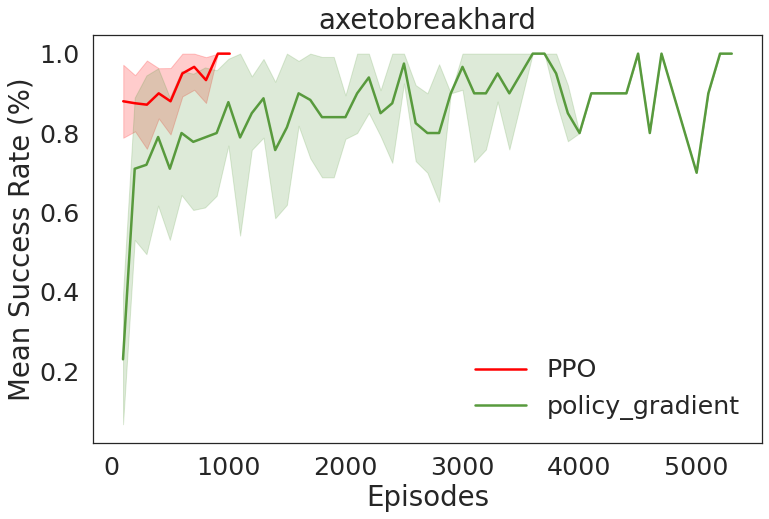

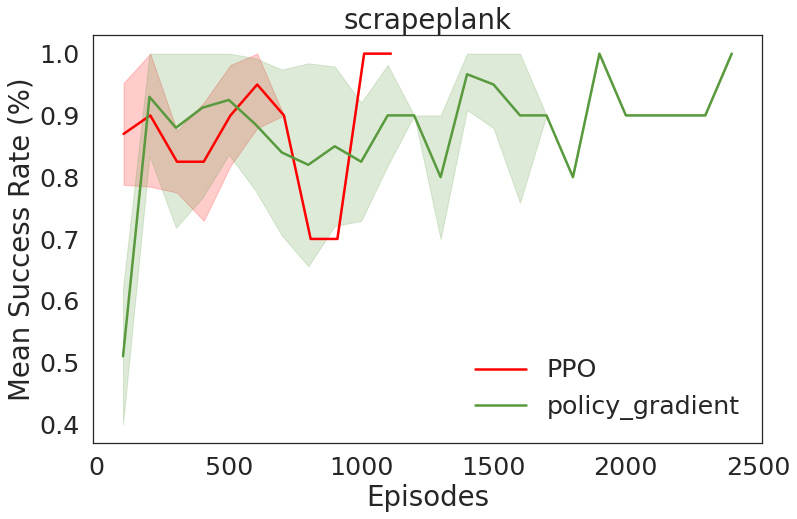

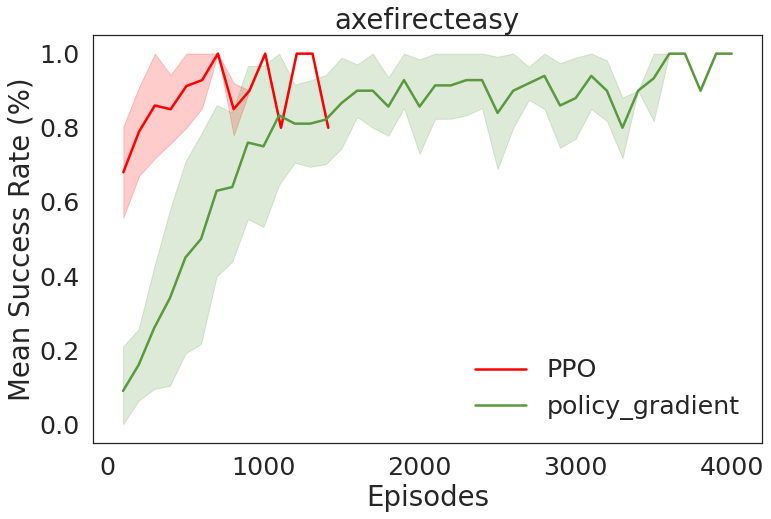

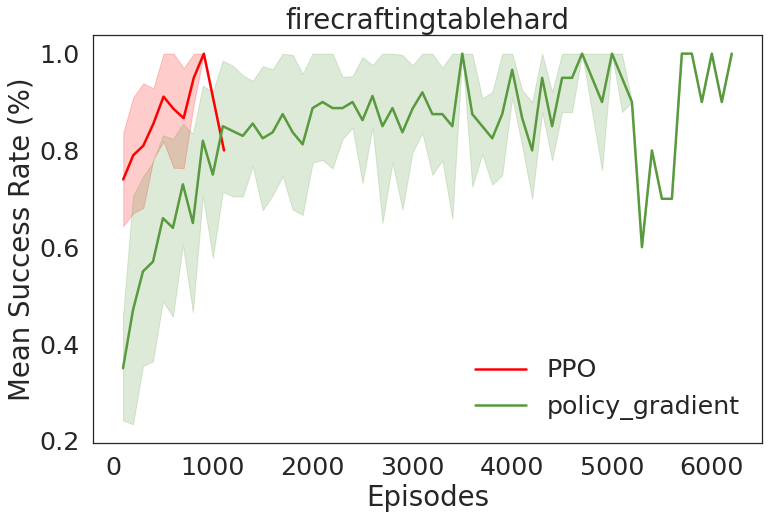

In [61]:
for novelty in novelties:
    novelty_graph_df = graph_df.loc[graph_df["novelty"] == novelty]
    fig, ax = plt.subplots(figsize=(12,7.5))

    for name, color in {'PPO': '#ff0001', 'policy_gradient': '#589A3D'}.items():
        sub_df = novelty_graph_df[novelty_graph_df.experiment == name]
        ax.plot(sub_df["episode_counter mean mean"], sub_df["success mean mean"], label=name, linestyle = 'solid', linewidth = 2.5,antialiased=True, color=color)
        ax.fill_between(sub_df["episode_counter mean mean"], sub_df["lower_std"], sub_df["upper_std"], alpha=0.2, antialiased=True, color=color)
        ax.set_title(novelty)
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Mean Success Rate (%)")   
        ax.legend()
        plt.savefig(f'{repo_dir}/plots/{novelty}.png')